### Example: Rods
Using the same system setup as for the ideal chain, we setup a system of non-interacting polymer chains, run a short simulation, and examine the resulting trajectory.

In [1]:
import h5py
import numpy as np
from scipy.spatial.transform import Rotation as R


def setup_system(box_size, n_molecules, chain_length, out_path, bond_length=0.5):
    """Setup a simple system of polymer chains
    
    Parameters
    ----------
    box_size : list of float
        Simulation box size in nm.
    n_molecules : int
        Total number of molecules of `chain_length` monomer units.
    chain_length : int
        Length of each polymer chain in number of monomers.
    out_path : str
        Path of the created structure file.
    bond_length : float, optional
        Length of intramolecular bonds in the chains.
    """
    box_size = np.asarray(box_size, dtype=np.float32)
    n_particles = n_molecules * chain_length
    
    with h5py.File(out_path, "w") as out_file:
        position_dataset = out_file.create_dataset(
            "coordinates",
            (1, n_particles, box_size.size,),
            dtype="float32",
        )
        types_dataset = out_file.create_dataset(
            "types",
            (n_particles,),
            dtype="i",
        )
        names_dataset = out_file.create_dataset(
            "names",
            (n_particles,),
            dtype="S10",
        )
        indices_dataset = out_file.create_dataset(
            "indices",
            (n_particles,),
            dtype="i",
        )
        molecules_dataset = out_file.create_dataset(
            "molecules",
            (n_particles,),
            dtype="i",
        )
        bonds_dataset = out_file.create_dataset(
            "bonds",
            (n_particles, 3,),
            dtype="i",
        )
    
        head_positions = np.random.uniform(
            low=np.zeros_like(box_size),
            high=box_size,
            size=(n_molecules, box_size.size,),
        )
        
        # Randomly coiled chains
        for i in range(n_molecules):
            position_dataset[0, i*chain_length, :] = head_positions[i, :]
            for j in range(1, chain_length):
                position_dataset[0, i*chain_length + j, :] = (
                    head_positions[i, :] 
                    + R.random().as_matrix().dot(np.array([
                        bond_length, 0.0, 0.0,
                    ]))
                )
                            
        types_dataset[...] = 0
        names_dataset[...] = np.string_("A")
        indices_dataset[...] = np.arange(n_particles)
    
        # molecules
        molecules_dataset[...] = np.repeat(np.arange(n_molecules), chain_length)
        
        # bonds
        bonds_dataset[...] = -1
        bonds_dataset[:, 0] = np.arange(n_particles) - 1
        bonds_dataset[::chain_length, 0] = -1
        
        bonds_dataset[:, 1] = np.arange(n_particles) + 1
        bonds_dataset[chain_length-1::chain_length, 1] = -1
# ==============================================================================

# 15 chains in a 30nm x 30nm x 30nm simulation box.
setup_system([30, 30, 30], 15, 10, "rods.HDF5")

### Run the simulation
Disable the field interactions with `--disable-field`.

```bash
mpirun -n 6 python3 /Users/mortenledum/Documents/HyMD/hymd/__main__.py \
                    rods.toml         \
                    rods.HDF5         \
                    --disable-field   \
                    --seed 1          \
                    --verbose 1
```

### Examine the trajectory
We calculate the average radius of gyration of the rods, and compare to the gyration radius of the ideal chains.

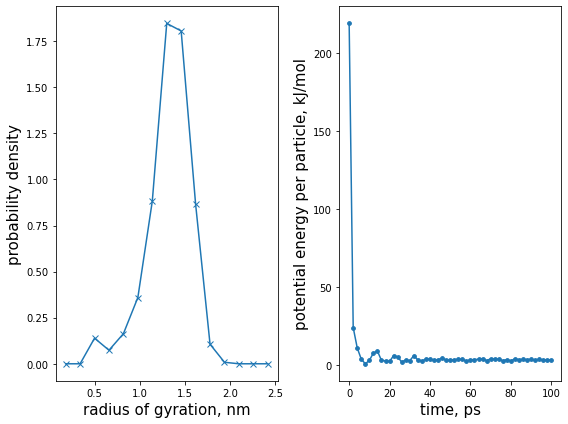

In [5]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

with h5py.File("sim.h5", "r") as in_file:
    time = in_file["/particles/all/position/time"][...]
    positions = in_file["/particles/all/position/value"][...]
    potential_energy = in_file["/observables/potential_energy/value"][...]
    molecules = in_file["/parameters/vmd_structure/resid"][...]
    box_size = in_file["/particles/all/box/edges"][...]
    n_particles = positions.shape[1]
    n_steps = time.shape[0]

    
unique_molecules = np.unique(molecules)
n_molecules = len(unique_molecules)
G = np.zeros(shape=(n_steps, n_molecules,), dtype=np.float64)

for i in range(n_molecules):
    ind = np.where(molecules == unique_molecules[i])
    chain_length = len(ind[0])    
    
    # make molecule whole
    r = np.squeeze(positions[:, ind, :])
    for j in range(1, chain_length):
        for k in range(n_steps):
            for dim in range(box_size.size):
                dr = r[k, j, dim] - r[k, 0, dim]
                if dr > 0.5 * box_size[dim]:
                    r[k, j, dim] -= box_size[dim]
                if dr <= -0.5 * box_size[dim]:
                    r[k, j, dim] += box_size[dim]
    
    r_mean = np.squeeze(np.mean(r, axis=1))
    dr = r - r_mean[:, None, :]
    dr_squared = np.squeeze(np.apply_over_axes(np.sum, dr**2, [1, 2,]))
    G[:, i] = np.sqrt(dr_squared / chain_length)

hist, bins = np.histogram(G, bins=15, range=(0.1, 2.5), density=True)

fig, axs = plt.subplots(1, 2)
fig.set_figwidth(8)
fig.set_figheight(6)
font_opts = {"fontsize": 15}

axs[0].plot(bins[:-1] + 0.5 * np.diff(bins), hist, "-x")
axs[0].set_xlabel("radius of gyration, nm", **font_opts)
axs[0].set_ylabel("probability density", **font_opts)

axs[1].plot(time, potential_energy / n_particles, "-", marker=".", markersize=7.5)
axs[1].set_xlabel("time, ps", **font_opts)
axs[1].set_ylabel("potential energy per particle, kJ/mol", **font_opts)

fig.tight_layout()
plt.show()